In [1]:
import numpy as np
import pandas as pd
import os
from joblib import Parallel, delayed
import multiprocessing
from ipywidgets import interactive
import matplotlib.pyplot as plt 

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting plotting parameters
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18) 

In [4]:
df_dir = r'F:\1. UTSA Ph.D\2. NASA ODPO\1. Tests\FST_402\Results'
os.chdir(df_dir)

In [5]:
file = r'Object Tracking 3D.xlsx'

df = pd.read_excel(file)
df = df.drop('Unnamed: 0', axis = 1)

In [6]:
df.head()

,Image #,Time,C_Mx,C_My,C_Mz,Vx,Vy,Vz,Ax,Ay,Az,Theta,Psi,Theta_dot,Psi_dot,Omega_dot_dot,Psi_dot_dot
0,1324,0.00,0.000000,0.0,0.0,5.047319,0.0,0.0,2.273737e-08,0.0,0.0,3.735629,-9.571425,-2010.216766,0.000000,0,0.000000e+00
1,1325,0.05,0.252366,0.0,0.0,5.047319,0.0,0.0,-2.523659e+04,0.0,0.0,3.635119,-9.571425,22.294958,0.000000,0,6.059353e+07
2,1326,0.10,0.504732,0.0,0.0,2.523659,0.0,0.0,-2.523659e+04,0.0,0.0,3.737859,-9.571425,1063.861185,6059.353151,0,3.219605e+07
3,1327,0.15,0.504732,0.0,0.0,2.523659,0.0,0.0,2.523659e+04,0.0,0.0,3.741505,-8.965490,-1271.352101,3219.605360,0,-9.158896e+07
4,1328,0.20,0.757098,0.0,0.0,5.047319,0.0,0.0,-2.842171e-09,0.0,0.0,3.610724,-9.249465,108.853352,-3099.543095,0,-6.459918e+07


In [7]:
# Save the important data into a dataframe

col_names = ['Image #', 'Time', 'C_Mx', 'C_My', 'C_Mz', 'Vx', 'Vy', 'Vz', 'Ax', 'Ay', 'Az', 'Theta', 'Psi', 'Theta_dot', 'Psi_dot', 'Omega_dot_dot', 'Psi_dot_dot']
df_fit = pd.DataFrame(np.zeros((len(df.Time),len(col_names))),columns=col_names)
df_fit['Image #'] = df['Image #']
df_fit.Time = df.Time

In [8]:
f = 20000

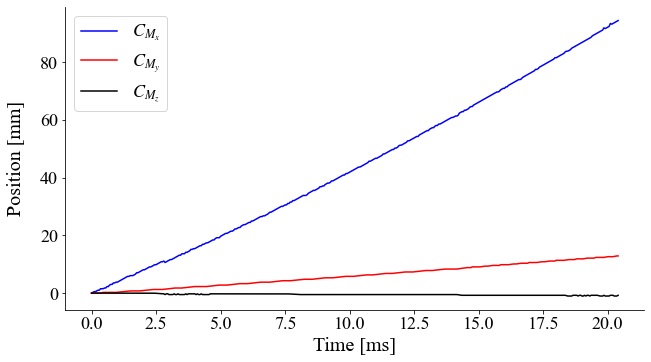

In [13]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)

plt.plot(df.Time, df.C_Mx, 'b', label = r'$C_{M_{x}}$')
plt.plot(df.Time, df.C_My, 'r', label = r'$C_{M_{y}}$')
plt.plot(df.Time, df.C_Mz, 'k', label = r'$C_{M_{z}}$')


plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel('Position [mm]', rotation = 90, fontsize = 20, labelpad=15)

plt.legend(fontsize = 18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

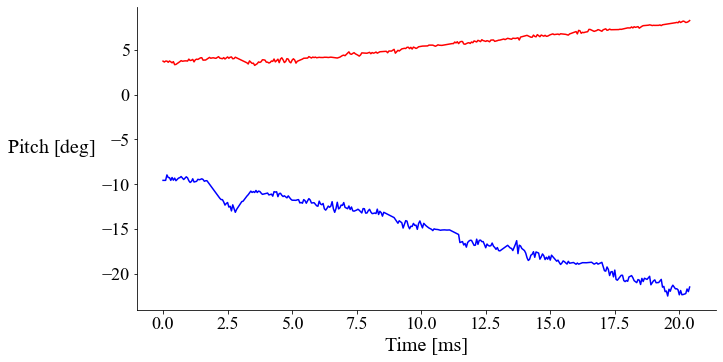

In [9]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)


plt.plot(df.Time,df.Theta, 'r')
plt.plot(df.Time,df.Psi, 'b')

plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel(r'Pitch [$\deg$]', rotation = 0, fontsize = 20, labelpad=50)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.tick_params(axis = "y", which = "both", left = False, right = False)

#plt.ylim(0,10)

plt.show()

In [85]:
# Fit the X center of mass coordinate

def f(n):
    x = df.Time
    y = df.C_Mx

    curve_model = np.poly1d(np.polyfit(x, y, n))

    curve_fitting_line = np.linspace(x.min(), x.max(), 1000)
    

    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)
    fig.tight_layout(pad=5.0)
    
    plt.scatter(x, y, color = 'r')
    plt.plot(curve_fitting_line, curve_model(curve_fitting_line))
    plt.xlabel('Time [ms]', fontsize = 20)
    plt.ylabel('Position [mm]', rotation = 0, fontsize = 20, labelpad=55)
    plt.title(r'$C_{M,x}$ Curve Fit Using n = '+str(n), fontsize = 22)
    plt.show()


interactive_plot= interactive(f,n=(1,4))
interactive_plot

interactive(children=(IntSlider(value=2, description='n', max=4, min=1), Output()), _dom_classes=('widget-inte…

In [86]:
# Save the fit to the new dataframe
x = df.Time
y = df.C_Mx

order = 2

coeffs = np.poly1d(np.polyfit(x, y, order))
fit = np.squeeze(np.zeros((len(df.Time),1)))
V_fit = np.squeeze(np.zeros((len(df.Time),1)))
A_fit = np.squeeze(np.zeros((len(df.Time),1)))

fit_string = []

for i,c in enumerate(coeffs):
    fit = fit + c*df.Time**(order-i)
    V_fit = V_fit + c*(order-i)*df.Time**(order-i-1)
    A_fit = A_fit + c*(order-i)*(order-i-1)*df.Time**(order-i-2)*1000
    fit_string.append(str(round(c,4)) + 't^' + str(order-i))
    
print('Curve Fit:')
print(fit_string)

df_fit['C_Mx'] = fit
df_fit['Vx'] = V_fit
df_fit['Ax'] = A_fit

Curve Fit:
['0.0431t^2', '3.754t^1', '-0.0011t^0']


In [87]:
# Fit the X center of mass coordinate

def f(n):
    x = df.Time
    y = df.C_My

    curve_model = np.poly1d(np.polyfit(x, y, n))

    curve_fitting_line = np.linspace(x.min(), x.max(), 1000)

    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)
    fig.tight_layout(pad=5.0)
    
    plt.scatter(x, y, color = 'r')
    plt.plot(curve_fitting_line, curve_model(curve_fitting_line))
    plt.xlabel('Time [ms]', fontsize = 20)
    plt.ylabel('Position [mm]', rotation = 0, fontsize = 20, labelpad=55)
    plt.title(r'$C_{M,y}$ Curve Fit Using n = '+str(n), fontsize = 22)
    plt.show()


interactive_plot= interactive(f,n=(1,4))
interactive_plot

interactive(children=(IntSlider(value=2, description='n', max=4, min=1), Output()), _dom_classes=('widget-inte…

In [88]:
# Save the fit to the new dataframe
x = df.Time
y = df.C_My

order = 2

coeffs = np.poly1d(np.polyfit(x, y, order))
fit = np.squeeze(np.zeros((len(df.Time),1)))
V_fit = np.squeeze(np.zeros((len(df.Time),1)))
A_fit = np.squeeze(np.zeros((len(df.Time),1)))

fit_string = []

for i,c in enumerate(coeffs):
    fit = fit + c*df.Time**(order-i)
    V_fit = V_fit + c*(order-i)*df.Time**(order-i-1)
    A_fit = A_fit + c*(order-i)*(order-i-1)*df.Time**(order-i-2)*1000
    fit_string.append(str(round(c,4)) + 't^' + str(order-i))
    
print('Curve Fit:')
print(fit_string)

df_fit['C_My'] = fit
df_fit['Vy'] = V_fit
df_fit['Ay'] = A_fit

Curve Fit:
['0.0041t^2', '0.5573t^1', '-0.1626t^0']


In [89]:
# Fit the X center of mass coordinate

def f(n):
    x = df.Time
    y = df.C_Mz

    curve_model = np.poly1d(np.polyfit(x, y, n))

    curve_fitting_line = np.linspace(x.min(), x.max(), 1000)

    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)
    fig.tight_layout(pad=5.0)
    
    plt.scatter(x, y, color = 'r')
    plt.plot(curve_fitting_line, curve_model(curve_fitting_line))
    plt.xlabel('Time [ms]', fontsize = 20)
    plt.ylabel('Position [mm]', rotation = 0, fontsize = 20, labelpad=55)
    plt.title(r'$C_{M,z}$ Curve Fit Using n = '+str(n), fontsize = 22)
    plt.show()


interactive_plot= interactive(f,n=(1,4))
interactive_plot

interactive(children=(IntSlider(value=2, description='n', max=4, min=1), Output()), _dom_classes=('widget-inte…

In [90]:
# Save the fit to the new dataframe
x = df.Time
y = df.C_Mz

order = 2

coeffs = np.poly1d(np.polyfit(x, y, order))
fit = np.squeeze(np.zeros((len(df.Time),1)))
V_fit = np.squeeze(np.zeros((len(df.Time),1)))
A_fit = np.squeeze(np.zeros((len(df.Time),1)))

fit_string = []

for i,c in enumerate(coeffs):
    fit = fit + c*df.Time**(order-i)
    V_fit = V_fit + c*(order-i)*df.Time**(order-i-1)
    A_fit = A_fit + c*(order-i)*(order-i-1)*df.Time**(order-i-2)*1000
    fit_string.append(str(round(c,4)) + 't^' + str(order-i))
    
print('Curve Fit:')
print(fit_string)

df_fit['C_Mz'] = fit
df_fit['Vz'] = V_fit
df_fit['Az'] = A_fit

Curve Fit:
['0.0002t^2', '-0.0468t^1', '-0.0327t^0']


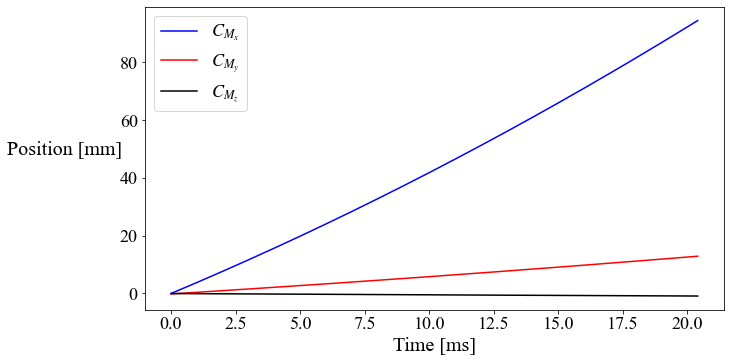

In [91]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)

plt.plot(df_fit.Time, df_fit.C_Mx, 'b', label = r'$C_{M_{x}}$')
plt.plot(df_fit.Time, df_fit.C_My, 'r', label = r'$C_{M_{y}}$')
plt.plot(df_fit.Time, df_fit.C_Mz, 'k', label = r'$C_{M_{z}}$')


plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel('Position [mm]', rotation = 0, fontsize = 20, labelpad=55)

plt.legend(fontsize = 18)


plt.show()

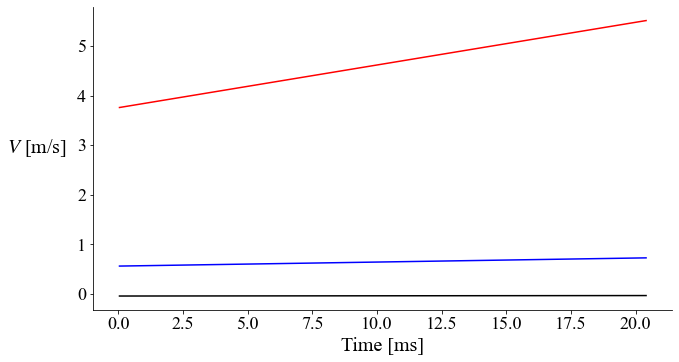

In [92]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)

plt.plot(df_fit.Time, df_fit.Vx, 'r')
plt.plot(df_fit.Time, df_fit.Vy, 'b')
plt.plot(df_fit.Time, df_fit.Vz, 'k')


plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel(r'$V$ [m/s]', rotation = 0, fontsize = 20, labelpad=40)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.tick_params(axis = "y", which = "both", left = False, right = False)

#plt.ylim(-1,8)

plt.show()

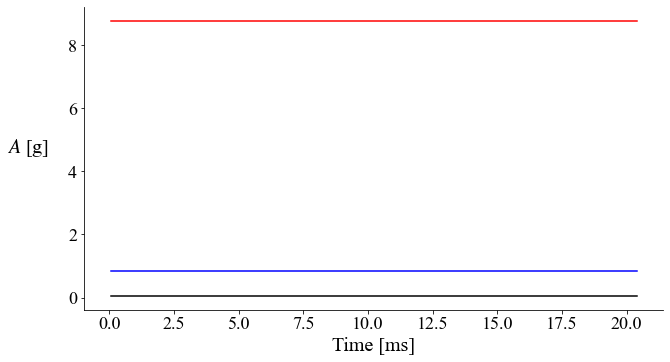

In [95]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)

g = 9.81

plt.plot(df_fit.Time, df_fit.Ax/g, 'r')
plt.plot(df_fit.Time, df_fit.Ay/g, 'b')
plt.plot(df_fit.Time, df_fit.Az/g, 'k')


plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel(r'$A$ [g]', rotation = 0, fontsize = 20, labelpad=40)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.tick_params(axis = "y", which = "both", left = False, right = False)

#plt.ylim(-100,100)

plt.show()

In [119]:
# Fit the X center of mass coordinate

def f(n):
    x = df.Time
    y = df.Theta

    curve_model = np.poly1d(np.polyfit(x, y, n))

    curve_fitting_line = np.linspace(x.min(), x.max(), 1000)

    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)
    fig.tight_layout(pad=5.0)
    
    plt.scatter(x, y, color = 'r')
    plt.plot(curve_fitting_line, curve_model(curve_fitting_line))
    plt.xlabel('Time [ms]', fontsize = 20)
    plt.ylabel(r'$\theta$ [rad]', rotation = 0, fontsize = 20, labelpad=55)
    plt.title(r'$\theta$ Curve Fit Using n = '+str(n), fontsize = 22)
    plt.show()


interactive_plot= interactive(f,n=(1,4))
interactive_plot

interactive(children=(IntSlider(value=2, description='n', max=4, min=1), Output()), _dom_classes=('widget-inte…

In [120]:
# Save the fit to the new dataframe
x = df.Time
y = df.Theta

order = 2

coeffs = np.poly1d(np.polyfit(x, y, order))
fit = np.squeeze(np.zeros((len(df.Time),1)))
V_fit = np.squeeze(np.zeros((len(df.Time),1)))
A_fit = np.squeeze(np.zeros((len(df.Time),1)))

fit_string = []

for i,c in enumerate(coeffs):
    fit = fit + c*df.Time**(order-i)
    V_fit = V_fit + c*(order-i)*df.Time**(order-i-1)*1000
    A_fit = A_fit + c*(order-i)*(order-i-1)*df.Time**(order-i-2)*1000**2
    fit_string.append(str(round(c,4)) + 't^' + str(order-i))
    
print('Curve Fit:')
print(fit_string)

df_fit['Theta'] = fit
df_fit['Theta_dot'] = V_fit
df_fit['Theta_dot_dot'] = A_fit

Curve Fit:
['0.0064t^2', '0.109t^1', '3.4769t^0']


In [101]:
# Fit the X center of mass coordinate

def f(n):
    x = df.Time
    y = df.Psi

    curve_model = np.poly1d(np.polyfit(x, y, n))

    curve_fitting_line = np.linspace(x.min(), x.max(), 1000)

    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)
    fig.tight_layout(pad=5.0)
    
    plt.scatter(x, y, color = 'r')
    plt.plot(curve_fitting_line, curve_model(curve_fitting_line))
    plt.xlabel('Time [ms]', fontsize = 20)
    plt.ylabel(r'$\Psi$ [rad]', rotation = 0, fontsize = 20, labelpad=55)
    plt.title(r'$\Psi$ Curve Fit Using n = '+str(n), fontsize = 22)
    plt.show()


interactive_plot= interactive(f,n=(1,4))
interactive_plot

interactive(children=(IntSlider(value=2, description='n', max=4, min=1), Output()), _dom_classes=('widget-inte…

In [115]:
# Save the fit to the new dataframe
x = df.Time
y = df.Psi

order = 2

coeffs = np.poly1d(np.polyfit(x, y, order))
fit = np.squeeze(np.zeros((len(df.Time),1)))
V_fit = np.squeeze(np.zeros((len(df.Time),1)))
A_fit = np.squeeze(np.zeros((len(df.Time),1)))

fit_string = []

for i,c in enumerate(coeffs):
    fit = fit + c*df.Time**(order-i)
    V_fit = V_fit + c*(order-i)*df.Time**(order-i-1)*1000
    A_fit = A_fit + c*(order-i)*(order-i-1)*df.Time**(order-i-2)*1000**2
    fit_string.append(str(round(c,4)) + 't^' + str(order-i))
    
print('Curve Fit:')
print(fit_string)

df_fit['Psi'] = fit
df_fit['Psi_dot'] = V_fit
df_fit['Psi_dot_dot'] = A_fit

Curve Fit:
['-0.01t^2', '-0.4235t^1', '-9.4834t^0']


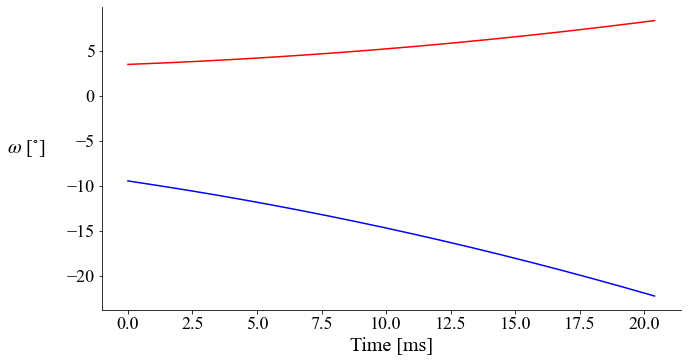

In [136]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)

plt.plot(df_fit.Time, df_fit.Theta, 'r')

plt.plot(df_fit.Time, df_fit.Psi, 'b')

plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel(r'$\omega$ [$^{\circ}}$]', rotation = 0, fontsize = 20, labelpad=40)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.tick_params(axis = "y", which = "both", left = False, right = False)

#plt.ylim(-1,8)

plt.show()

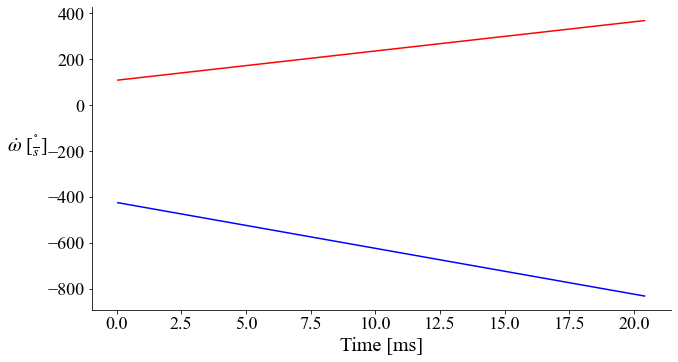

In [133]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)

plt.plot(df_fit.Time, df_fit.Theta_dot, 'r')

plt.plot(df_fit.Time, df_fit.Psi_dot, 'b')

plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel(r'$\dot{\omega} $ [$\frac{^{\circ}}{s}$]', rotation = 0, fontsize = 20, labelpad=20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.tick_params(axis = "y", which = "both", left = False, right = False)

#plt.ylim(-1,8)

plt.show()

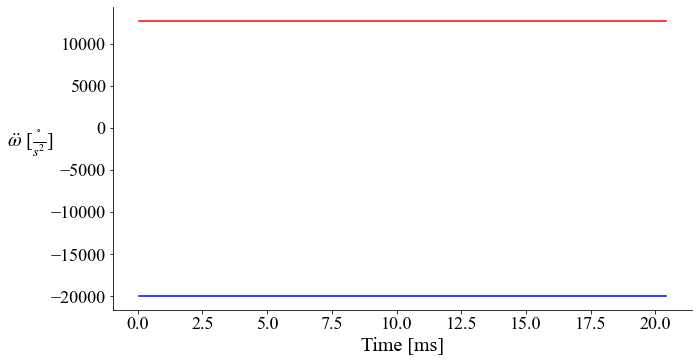

In [132]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)

plt.plot(df_fit.Time, df_fit.Theta_dot_dot, 'r')

plt.plot(df_fit.Time, df_fit.Psi_dot_dot, 'b')

plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel(r'$\ddot{\omega} $ [$\frac{^{\circ}}{s^2}$]', rotation = 0, fontsize = 20, labelpad=20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.tick_params(axis = "y", which = "both", left = False, right = False)

#plt.ylim(-1,8)

plt.show()

In [137]:
df_fit.head()

,Image #,Time,C_Mx,C_My,C_Mz,Vx,Vy,Vz,Ax,Ay,Az,Theta,Psi,Theta_dot,Psi_dot,Omega_dot_dot,Psi_dot_dot,Theta_dot_dot
0,1324,0.00,-0.001146,-0.162585,3.036005,NaN,NaN,NaN,NaN,NaN,NaN,3.476880,-9.483414,NaN,NaN,0.0,NaN,NaN
1,1325,0.05,0.186661,-0.134710,3.047954,3.758276,0.557718,0.238968,86.221547,8.14536,0.0,3.482344,-9.504613,109.617379,-424.490573,0.0,-19980.83235,12743.870904
2,1326,0.10,0.374682,-0.106814,3.059902,3.762587,0.558125,0.238968,86.221547,8.14536,0.0,3.487841,-9.525863,110.254573,-425.489615,0.0,-19980.83235,12743.870904
3,1327,0.15,0.562919,-0.078897,3.071850,3.766898,0.558532,0.238968,86.221547,8.14536,0.0,3.493370,-9.547162,110.891766,-426.488656,0.0,-19980.83235,12743.870904
4,1328,0.20,0.751372,-0.050960,3.083799,3.771209,0.558939,0.238968,86.221547,8.14536,0.0,3.498930,-9.568512,111.528960,-427.487698,0.0,-19980.83235,12743.870904


In [124]:
save_df = 1 # Chose to save the dataframe or not
df_file = 'FST 402 3D Curve Fits.xlsx'

# Saving run_matrix
if save_df == 1:
    df_fit.to_excel(df_file)